In [1]:
from util_phys import *
from util_phys_ROOT import *

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
sol = 29.9792458
mpip = 0.13957018
mp = 0.93827203

def etime(evt):
    isc = evt.sc[0]-1
    return evt.sc_t[isc] - evt.sc_r[isc]/sol

def bifp(p):
    return math.sqrt(p**2/(p**2+mp**2))

def dtifp(p, d, t, t0):
    return t - d/(sol*bifp(p)) - t0


In [3]:
def hid_pos_runs(N=None, n0=0):
    n = n0
    hid_branches = [ 'q', 'p', 'tr_time', 'sc', 'sc_sect', 'sc_pd', 'sc_r', 'sc_t' ]
    tname = 'h10clone/h10'
    dir_skims = '/home/ephelps/projects/phys-ana-omega/e1f6/test' #'/hdd500/home/data/batch/e1f_skim'
    fn_tmpl = '%s/%%d.root'%dir_skims
    exceptional_runs = [37688]
    runs = [(run, fn_tmpl%run) for run in golden_runs if run not in exceptional_runs]
    nruns = len(runs)
    N = nruns if N is None else N
    while n-n0 < N and n < nruns:
        (run, fn) = runs[n]
        yield (run, root_numpy.root2rec(fn_tmpl%run, tname, hid_branches))
        n += 1
# %time runs = [root_numpy.root2rec(fn_tmpl%grun, tname, bnames) \
#               for grun in golden_runs[0:50] if grun not in exceptional_runs]
# %time hid_pos_runs = [(grun, root_numpy.root2rec(fn_tmpl%grun, tname, hid_branches)) \
#                       for grun in golden_runs if grun not in exceptional_runs]

In [4]:
def positive_particles(run):
    dts = []
    for i, (pS, qS, scS) in enumerate(zip(run.p, run.q, run.sc)):
        for p, q, sc in zip(pS, qS, scS):
            if q > 0 and sc > 0 and p > 0 and p < 5.5:
                #if run.sc_sect[i][sc-1] == 3 and run.sc_pd[i][sc-1] == 24:
                d = run.sc_r[i][sc-1]
                t = run.sc_t[i][sc-1]
                t0 = run.tr_time[i]
                dts.append((run.sc_sect[i][sc-1], run.sc_pd[i][sc-1], dtifp(p, d, t, t0)))
    return dts

In [5]:
# golden_runs = [37658, 37659, 37661, 37662]
%time run_dtsS = [(run, positive_particles(d_run)) for (run, d_run) in hid_pos_runs()]

CPU times: user 56min 13s, sys: 11 s, total: 56min 24s
Wall time: 56min 29s


In [6]:
# runs, peaks = [], []
# for (run, dts) in run_dtsS:
#     for sect, pdl, dt in dts:
#         if sect == 3 and pdl == 24:
#             Y,X = np.histogram(dt, bins=np.arange(-5,5,0.25))
#             runs.append(run)
#             peak = max(zip(X,Y), key=lambda x: x[1])
#             peaks.append(peak[0])
#             #print(run, peak)
runs, peaks = [], []
for (run, dts) in run_dtsS:
    Y,X = np.histogram([dt for (sect,pdl,dt) in dts if sect==1 and pdl==24], bins=np.arange(-5,5,0.1))
    runs.append(run)
    peak = max(zip(X,Y), key=lambda x: x[1])
    peaks.append(peak[0])

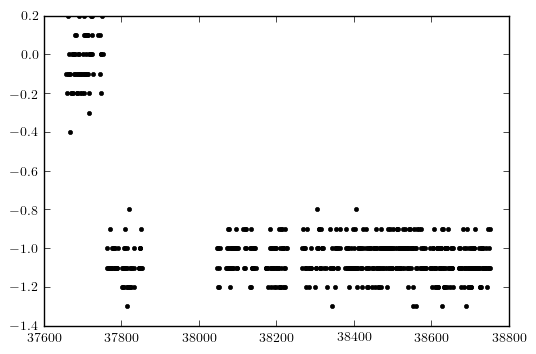

In [7]:
plt.plot(runs, peaks, 'k.')
# for i,(r,p) in enumerate(zip(runs,peaks),1):
#     print(i,r,p)
#     if i>10:
#         break
# plt.hist2d(runs,peaks)
# run_dtsS

In [105]:
def get_peak_points(h):
    points = []
    pfinder = ROOT.TSpectrum(4)
    npeaks = pfinder.Search(h, 2, 'goff', 0.5)
    for i in range(0,npeaks):
        x = pfinder.GetPositionX()[i]
        y = pfinder.GetPositionY()[i]
        points.append((x,y))
    return points

def get_hist_peaks(run, dtsS, sect, pdl):
    dts = [d for (r,d) in dtsS if r==run][0]
    h = ROOT.TH1D('hdt', 'hdt', 500, -45, 5)
    for (s,p,dt) in dts:
        if s==sect and p==pdl:
            h.Fill(dt)
    peaks = get_peak_points(h)
    dt = max([p[0] for p in peaks]) if len(peaks) > 0 else 0
    return (h,peaks,dt)

In [102]:
%%time
runs, peaks = [], []
runs_e, peaks_e = [], []
for (run, dts) in run_dtsS:
    (h,peaks1,dt) = get_hist_peaks(run, run_dtsS, 3, 11)
    if len(peaks1)>0 and len(peaks1)<3:
        runs.append(run)
        peaks.append(dt)
    else:
        runs_e.append(run)
        peaks_e.append(dt)
    del h
#     break

CPU times: user 58.4 s, sys: 60 ms, total: 58.5 s
Wall time: 58.4 s


In [87]:
[(r,p) for (r,p) in zip(runs,peaks) if p<=0.5 and r>38000]

[(38050, -0.1499999999999993),
 (38093, 0),
 (38141, 0),
 (38143, 0),
 (38196, -2.25),
 (38198, 0),
 (38217, 0),
 (38221, 0),
 (38301, -0.3499999999999995),
 (38322, 0),
 (38391, 0),
 (38395, 0),
 (38398, 0),
 (38403, 0),
 (38405, 0),
 (38411, 0),
 (38412, 0),
 (38438, 0),
 (38453, -0.24999999999999983),
 (38492, 0),
 (38527, 0),
 (38540, 0),
 (38542, 0),
 (38549, 0),
 (38551, 0),
 (38578, 0),
 (38579, 0.45000000000000034),
 (38611, 0),
 (38619, 0),
 (38622, 0),
 (38631, 0),
 (38638, 0),
 (38656, 0),
 (38671, 0),
 (38685, 0),
 (38698, 0),
 (38724, 0),
 (38732, 0),
 (38735, 0),
 (38745, 0)]

INFO:ROOT.TCanvas.Print] png file /tmp/tmp2yoyenkx.png has been created


[(2.45, 13.0), (-0.1499999999999993, 11.0)]
2.45


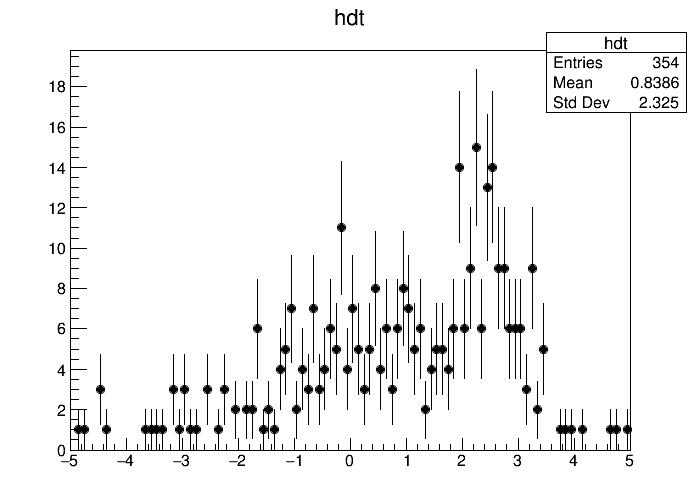

In [97]:
(h,peaks,dt) = get_hist_peaks(38050, run_dtsS, 3, 11)
print(peaks)
print(dt)
asrootpy(h)

INFO:ROOT.TCanvas.Print] png file /tmp/tmpqj2vzrly.png has been created


[(-23.15, 1.0)]
-23.15


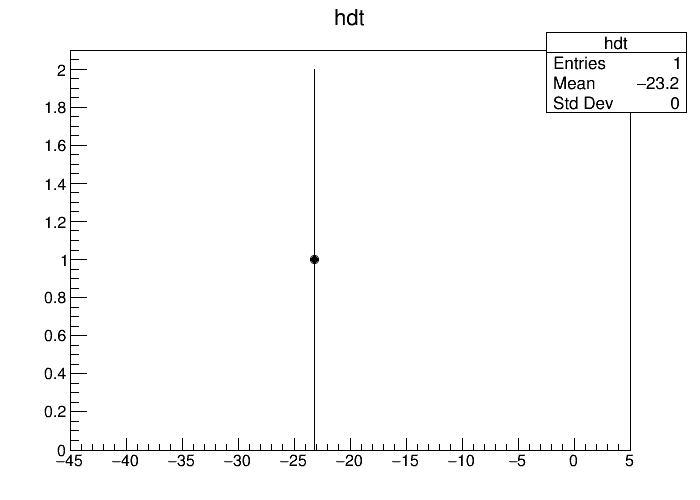

In [106]:
(h,peaks,dt) = get_hist_peaks(37772, run_dtsS, 3, 2)
print(peaks)
print(dt)
asrootpy(h)

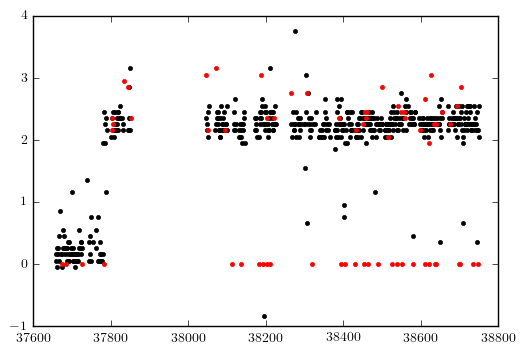

In [103]:
plt.plot(runs, peaks, 'k.')
plt.plot(runs_e, peaks_e, 'r.')
# plt.show()
# print(peaks)
# print(peaks1)
# print(get_peak_points(h))
# asrootpy(h)

In [9]:
run0, run1 = min(golden_runs), max(golden_runs)
print(run0,run1)

37658 37662


In [10]:
fout = root_open('pid_pos_per_run.root', 'recreate')
hpeaks = Hist(run1-run0+1, run0-0.5, run1+0.5, name='proton_dt_per_run')

nfiles = 0
nevs = 0

for (ifile, (run, fn)) in enumerate(runs, 1):
    if nfiles > 0 and ifile > nfiles: break

    fout.cd()

    hss = []
    for isect in range(0,6):
        hs = []
        for ipdl in range(0,50):
            h = Hist(40, -10, 10,
                     name='r%d_s%d_pdl%d_pid_pos'%(run, isect+1, ipdl+1))
            hs.append(h)
        hss.append(hs)

    fin = ROOT.TFile(fn)
    es = fin.Get(tname)
    ievt = 0
    while es.GetEvent(ievt):
        ievt += 1
        if nevs > 0 and ievt > nevs: break
        for q, p, sc in zip(bytearray(es.q), es.p, bytearray(es.sc)):
            q, sc = twos_comp(q), twos_comp(sc)
            if q > 0 and sc > 0 and p > 0 and p < 5.5:
                sect = twos_comp(bytearray(es.sc_sect)[sc-1])
                pdl = twos_comp(bytearray(es.sc_pd)[sc-1])
                d = es.sc_r[sc-1]
                t = es.sc_t[sc-1]
                t0 = es.tr_time
                hss[sect-1][pdl-1].Fill(dtifp(p, d, t, t0))
    fin.Close()
    h = hss[2][23]
    peaks = get_peak_points(h)
    dt = max([p[0] for p in peaks]) if len(peaks) > 0 else 0
    hpeaks.Fill(run, dt)

TypeError: 'int' object is not iterable

In [ ]:
hpeaks

In [23]:
fout = root_open('pid_pos_per_run.root', 'recreate')

nfiles = 0
nevs = 0

for (ifile, (run, fn)) in enumerate(runs, 1):
    if nfiles > 0 and ifile > nfiles: break

    fout.cd()
    hss = []
    for isect in range(0,6):
        hs = HistStack(name='r%d_s%d_pid_pos'%(run, isect+1))
        for ipdl in range(0,50):
            h = Hist2D(50,0,5,40,-10,10)
            h.name='r%d_s%d_pdl%d_pid_pos'%(run, isect+1, ipdl+1)
            h.set_option('colz')
            hs.Add(h)
        hss.append(hs)

    fin = ROOT.TFile(fn)
    es = fin.Get(tname)
    ievt = 0
    while es.GetEvent(ievt):
        ievt += 1
        if nevs > 0 and ievt > nevs: break
        for q, p, sc in zip(bytearray(es.q), es.p, bytearray(es.sc)):
            q, sc = twos_comp(q), twos_comp(sc)
            if q > 0 and sc > 0 and p > 0 and p < 5.5:
                sect = twos_comp(bytearray(es.sc_sect)[sc-1])
                pdl = twos_comp(bytearray(es.sc_pd)[sc-1])
                d = es.sc_r[sc-1]
                t = es.sc_t[sc-1]
                t0 = es.tr_time
                hss[sect-1][pdl-1].Fill(p, dtifp(p, d, t, t0))
    fin.Close()
    for hs in hss:
        fout.WriteObject(hs, hs.name)

fout.Close()

True

In [19]:
hss[3].Draw('pads colz')

('q', 'p', 'tr_time', 'sc', 'sc_sect', 'sc_pd', 'sc_r', 'sc_t')